# Feature Extraction from Speech Data with OpenSMILE and GeMaps config
## Audio data collected in the EEG MIST paradigm

In [4]:
import glob
import os
import subprocess
import numpy as np
import pandas as pd
from scipy.io import arff
from io import StringIO
from pathlib import Path
import re
from tqdm import tqdm

In [5]:
# Set Data Path
# DATA_PATH = "C:/Users/mitch/OneDrive - UGent/UGent/Projects/5. VOP project/Voice_and_App/"
BASE_PATH = "Z:/ghepmk_data/2020_EEGStudy1/"
DATA_PATH = BASE_PATH + "aligned_data"
# Set OpenSMILE Config Path
OPENSMILE_CONFIG = '"C:/Users/mitch/OneDrive - UGent/UGent/Topics/Facial/OpenSmile/opensmile-2.3.0/config/gemaps/GeMAPSv01a.conf"'

FEATURES_PATH = DATA_PATH + "/features_gemaps/"
RAW_PATH = "C:/Users/mitch/OneDrive - UGent/UGent/Projects/2. Vanhollebeke et al/Data/Actual/Audio_Jonas"


# Extract features

# THIS ONE IS IF GETTING DATA FROM ALIGNED_DATA

In [6]:
## Only run this cell ONCE (set to False if exctracted)

# THIS ONE IS IF GETTING DATA FROM ALIGNED_DATA
if False:
    # Create paths if not existed
    Path(FEATURES_PATH).mkdir(parents=True, exist_ok=True)

    def extract(source, destination):
        # Generate extraction command
        cmd = "C:/Users/mitch/OneDrive/Documents/UGent/Topics/Facial/OpenSmile/opensmile-2.3.0/SMILExtract_Release -C {} -I {} -O {}".format(OPENSMILE_CONFIG, source, destination)
    #     print(cmd)
        p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
        p.wait()

    for wav_file in tqdm(glob.glob(DATA_PATH + "/*/audio/*.wav")):
        participant_dir = wav_file.split("/")[-1]
        participant_dir = participant_dir.split("\\")[1]
        filename = re.findall(r'udio\\(.+).wav', wav_file)[0] # file name excluding .wav
#         filenum = re.findall(r'occ_(.+?).wav',wav_file)[0] # file number
        filenum = filename[filename.find('occ_')+4:filename.find('occ_')+6] # else it cant find exceptions like 99-2 or something

        if filenum == "99": # Something went wrong in the naming of the inital files and this is a quick fix
            filename = filename[:filename.find('occ_')+4] + "9" + filename[filename.find('occ_')+6:] # replace 99 by 9 but keep the rest
        
        out_path = FEATURES_PATH + "/" + participant_dir + "/" + filename + '.arff'

        wav_file = '"' + wav_file.replace(os.sep, '/') + '"'
        out_path = '"' + out_path + '"'
        
        Path(FEATURES_PATH + "/" + participant_dir + "/").mkdir(parents=True, exist_ok=True)
        
        extract(wav_file, out_path)
#         break     
#     print(out_path)

# THIS ONE IS IF GETTING DATA FROM LOCAL JONAS_DATA

In [7]:
## Only run this cell ONCE (set to False if exctracted)
count = 0
# THIS ONE IS IF GETTING DATA FROM LOCAL DATA
if False:
    # Create paths if not existed
    Path(FEATURES_PATH).mkdir(parents=True, exist_ok=True)

    def extract(source, destination):
        # Generate extraction command
        cmd = "C:/Users/mitch/OneDrive/Documents/UGent/Topics/Facial/OpenSmile/opensmile-2.3.0/SMILExtract_Release -C {} -I {} -O {}".format(OPENSMILE_CONFIG, source, destination)
    #     print(cmd)
        p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
        p.wait()

    for wav_file in tqdm(glob.glob(RAW_PATH + "/*/sentences*.wav")):
        participant_dir = re.findall(r'Jonas\\(.+?)\\sentences',wav_file)[0]
        filenum = re.findall(r'occ_(.+?).wav',wav_file)[0]

        if filenum == "99": # Something went wrong in the naming of the inital files and this is a quick fix
            filename = 'sentences_occ_' + '9'
        else:
            filename = 'sentences_occ_' + filenum

        out_path = FEATURES_PATH + "/" + participant_dir + "/" + filename + '.arff'

        wav_file = '"' + wav_file.replace(os.sep, '/') + '"'
        out_path = '"' + out_path + '"'

        Path(FEATURES_PATH + "/" + participant_dir + "/").mkdir(parents=True, exist_ok=True)

        extract(wav_file, out_path)
#         print(f'in file is: ', wav_file, ' and out file is: ', out_path)
#         break     
#     print(out_path)




# Load all Marloeses and compile into comprehensive df

In [10]:
if False: # Only used once to get everything into a nice .csv
    from arff2pandas import a2p
    dataMarloes = pd.DataFrame()
    for arff_file in tqdm(glob.glob(FEATURES_PATH + "/*/sentences*.arff")):
        participantNum = int(re.findall(r'features_gemaps\\(.+?)\\sentences',arff_file)[0])
        try:
            fileNum = int(re.findall(r'sentences_occ_(.+?).arff',arff_file)[0])

            with open(arff_file) as f:
                df = a2p.load(f)
                df.insert(0, "participantNum", participantNum) # Add column for participant Number
                df.insert(1, "fileNum", fileNum) # Add column for file Number
                dataMarloes = dataMarloes.append(df)
        except:
            print(f'Something wrong with file name of participant: ', participantNum, 'File number: ', fileNum + 1)
            
    dataMarloes.to_csv(FEATURES_PATH + 'marloesFeaturesCompiled.csv', encoding='utf-8', index=False)
    
dataMarloes = pd.read_csv(FEATURES_PATH + 'marloesFeaturesCompiled.csv') # Read .csv file

dataMarloes = dataMarloes[dataMarloes['fileNum'] != 9] # For now remove every first Marloes from the dataframe - we seem not to have any SAMs for these. 

# Rename column names because with the .arff files it got loaded weirdly
maxX = len(dataMarloes.columns)
count = 0

while count < maxX:
    if count > 2: # Skip a few
        name = dataMarloes.columns[count]
        name = name[0:name.find('@NUMERIC')] # Find where @NUMERIC starts and get everything in front of it
        dataMarloes.rename(columns={dataMarloes.columns[count]: name}, inplace=True) # Rename columns
    count = count + 1

# Add explicit responses from appData.csv

In [11]:
if False: # Only used once to get everything into a nice .csv
    dataSAM = pd.DataFrame()

    for csv_file in tqdm(glob.glob(DATA_PATH + "/*/audio/appData.csv")):
        participantNum = csv_file.split("/")[-1]
        participantNum = int(participantNum.split("\\")[1])

        temp = pd.read_csv(csv_file)
        for i in range(0, 9):
            d = {'participantNum': participantNum, 'fileNum': i, 'arousal': temp['arousals_' + str(i)], 'valence': temp['valences_' + str(i)], 'dominance': temp['dominances_' + str(i)]}
            df = pd.DataFrame(data=d)
            dataSAM = dataSAM.append(df)

    dataSAM.to_csv(FEATURES_PATH + 'SAMsCompiled.csv', encoding='utf-8', index=False) # Write CSV

dataSAM = pd.read_csv(FEATURES_PATH + 'SAMsCompiled.csv') # Read CSV
data = pd.merge(dataMarloes, dataSAM, on=["participantNum", "fileNum"]) # Put marloes and SAMS together for all complete sets

# Get Physiological Data

EDA

In [12]:
EDA_PATH = "Z:/ghepmk_data/2020_EEGStudy1_nosync/Data/aligned/EEG1_study_feat_stats/EEG1_study_feat_stats"

# Get aligned markers / timestamps

In [12]:
import bisect
import time

startlist = ['Controle1Slide', 'Controle2Slide', 'Controle3Slide', 'Stress1Slide', 'Stress2Slide', 'Stress3Slide']
stoplist = ['ControleSAM', 'ControleSAM3', 'ControleSAM4', 'StressSAM', 'StressSAM1', 'StressSAM2']
fileNums = [2, 3, 4, 6, 7, 8] # Relevant filenums for control and stress block

data["HR"] = np.nan
data["EDA"] = np.nan
data["SCR_Peaks"] = np.nan
t = time.time()

for p in tqdm(np.unique(data.participantNum)):
    file = DATA_PATH + '/' + str(p) + '/timeline_aligned.csv'
    print(f'currently processing file: ', file)
    if p != 68 | p != 79:
        if os.path.isfile(file):
            tempcsv = pd.read_csv(file)
            tempeda = pd.read_parquet('Z:/ghepmk_data/2020_EEGStudy1_nosync/Data/aligned/EEG1_study_feat_stats/EEG1_study_feat_stats/' + '/' + str(p) + '/gsr_processed.parquet', engine='pyarrow') # @Jonas, these are the files you sent me through Mattermost
            tempecg = pd.read_parquet(DATA_PATH + '/' + str(p) + '/edf_aligned/ecg.parquet', engine='pyarrow')

            tempcsv['t_start'] =  pd.to_datetime(tempcsv['t_start'])
            tempcsv['t_stop'] =  pd.to_datetime(tempcsv['t_stop'])

            for i in range(0,len(startlist)): 
                startstamp = tempcsv.t_start[np.where(tempcsv.Phase == startlist[i])[0][0]] # The timestamp of the start of this block
                stopstamp = tempcsv.t_start[np.where(tempcsv.Phase == stoplist[i])[0][0]] # Same but for the end of this block
                # ECG
                startLocECG = bisect.bisect_left(tempecg.timestamp,startstamp) # Find closest timestamp in the ecg data for start
                stopLocECG = bisect.bisect_left(tempecg.timestamp,stopstamp) # Same but for end
                #EDA
                startLocEDA = bisect.bisect_left(tempeda.index,startstamp)
                stopLocEDA = bisect.bisect_left(tempeda.index,stopstamp)

                # Average the data (this is probably pretty wrong) for the full segment to get one datapoint
                HR = tempecg.ECG_Rate[startLocECG:stopLocECG].mean()
                EDA = tempeda.processed_EDA[startLocEDA:stopLocEDA].mean()
                SCR_peaks = tempeda.SCR_Peaks_neurokit[startLocEDA:stopLocEDA].mean()

                location = np.where(np.logical_and(data['participantNum'] == p, data['fileNum'] == fileNums[i]))[0][0]
                data.at[location, 'HR'] = HR
                data.at[location, 'EDA'] = EDA
                data.at[location, 'SCR_Peaks'] = SCR_peaks
    #             break
    #         break
# tempcsv
elapsed = time.time() - t

  0%|                                                                                                                                                         | 0/79 [00:00<?, ?it/s]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/2/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/3/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/4/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/5/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/6/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/7/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/8/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/9/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/10/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/11/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/

 19%|███████████████████████████▎                                                                                                                    | 15/79 [00:22<01:37,  1.52s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/17/timeline_aligned.csv


 20%|█████████████████████████████▏                                                                                                                  | 16/79 [00:45<03:29,  3.33s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/18/timeline_aligned.csv


 22%|██████████████████████████████▉                                                                                                                 | 17/79 [01:04<05:19,  5.15s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/19/timeline_aligned.csv


 23%|████████████████████████████████▊                                                                                                               | 18/79 [01:25<07:18,  7.19s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/20/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/21/timeline_aligned.csv


 25%|████████████████████████████████████▍                                                                                                           | 20/79 [01:45<07:55,  8.06s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/22/timeline_aligned.csv


 27%|██████████████████████████████████████▎                                                                                                         | 21/79 [02:09<10:15, 10.61s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/23/timeline_aligned.csv


 28%|████████████████████████████████████████                                                                                                        | 22/79 [02:31<12:14, 12.88s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/24/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/26/timeline_aligned.csv


 30%|███████████████████████████████████████████▋                                                                                                    | 24/79 [02:50<10:47, 11.77s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/27/timeline_aligned.csv


 32%|█████████████████████████████████████████████▌                                                                                                  | 25/79 [03:13<12:29, 13.87s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/28/timeline_aligned.csv


 33%|███████████████████████████████████████████████▍                                                                                                | 26/79 [03:35<13:57, 15.80s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/29/timeline_aligned.csv


 34%|█████████████████████████████████████████████████▏                                                                                              | 27/79 [03:57<15:03, 17.37s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/30/timeline_aligned.csv


 35%|███████████████████████████████████████████████████                                                                                             | 28/79 [04:17<15:14, 17.93s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/31/timeline_aligned.csv


 37%|████████████████████████████████████████████████████▊                                                                                           | 29/79 [04:41<16:16, 19.53s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/32/timeline_aligned.csv


 38%|██████████████████████████████████████████████████████▋                                                                                         | 30/79 [05:02<16:19, 19.99s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/33/timeline_aligned.csv


 39%|████████████████████████████████████████████████████████▌                                                                                       | 31/79 [05:28<17:16, 21.60s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/34/timeline_aligned.csv


 41%|██████████████████████████████████████████████████████████▎                                                                                     | 32/79 [05:44<15:50, 20.21s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/35/timeline_aligned.csv


 42%|████████████████████████████████████████████████████████████▏                                                                                   | 33/79 [06:05<15:36, 20.37s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/36/timeline_aligned.csv


 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 34/79 [06:30<16:12, 21.61s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/37/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/38/timeline_aligned.csv


 46%|█████████████████████████████████████████████████████████████████▌                                                                              | 36/79 [06:52<12:02, 16.81s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/39/timeline_aligned.csv


 47%|███████████████████████████████████████████████████████████████████▍                                                                            | 37/79 [07:13<12:34, 17.97s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/40/timeline_aligned.csv


 48%|█████████████████████████████████████████████████████████████████████▎                                                                          | 38/79 [07:33<12:32, 18.35s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/41/timeline_aligned.csv


 49%|███████████████████████████████████████████████████████████████████████                                                                         | 39/79 [07:55<12:56, 19.42s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/42/timeline_aligned.csv


 51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 40/79 [08:14<12:32, 19.28s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/43/timeline_aligned.csv


 52%|██████████████████████████████████████████████████████████████████████████▋                                                                     | 41/79 [08:36<12:38, 19.97s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/44/timeline_aligned.csv


 53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 42/79 [09:00<12:59, 21.07s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/46/timeline_aligned.csv


 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 43/79 [09:19<12:22, 20.62s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/47/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/48/timeline_aligned.csv


 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 45/79 [09:37<08:38, 15.25s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/49/timeline_aligned.csv


 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 46/79 [09:56<08:58, 16.30s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/50/timeline_aligned.csv


 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                          | 47/79 [10:18<09:23, 17.60s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/51/timeline_aligned.csv


 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                        | 48/79 [10:37<09:17, 18.00s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/52/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/53/timeline_aligned.csv


 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 50/79 [11:02<07:37, 15.77s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/54/timeline_aligned.csv


 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 51/79 [11:31<08:47, 18.82s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/55/timeline_aligned.csv


 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 52/79 [11:50<08:25, 18.72s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/56/timeline_aligned.csv


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 53/79 [12:14<08:43, 20.12s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/57/timeline_aligned.csv


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 54/79 [12:39<09:00, 21.63s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/58/timeline_aligned.csv


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 55/79 [12:57<08:15, 20.63s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/59/timeline_aligned.csv


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 56/79 [13:15<07:33, 19.70s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/60/timeline_aligned.csv


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 57/79 [13:37<07:28, 20.37s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/61/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/63/timeline_aligned.csv


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 59/79 [13:56<05:08, 15.44s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/64/timeline_aligned.csv


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 60/79 [14:16<05:14, 16.55s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/65/timeline_aligned.csv


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 61/79 [14:36<05:16, 17.56s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/66/timeline_aligned.csv


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 62/79 [14:57<05:12, 18.41s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/67/timeline_aligned.csv


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 63/79 [15:14<04:49, 18.10s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/68/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/69/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/70/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/71/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/72/timeline_aligned.csv


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 68/79 [15:32<01:32,  8.39s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/73/timeline_aligned.csv


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 69/79 [15:53<01:44, 10.45s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/74/timeline_aligned.csv


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 70/79 [16:16<01:55, 12.88s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/75/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/76/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/77/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/78/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/79/timeline_aligned.csv
currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/80/timeline_aligned.csv


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76/79 [16:35<00:20,  6.84s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/81/timeline_aligned.csv


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77/79 [16:56<00:17,  8.63s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/82/timeline_aligned.csv


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78/79 [17:18<00:10, 10.80s/it]

currently processing file:  Z:/ghepmk_data/2020_EEGStudy1/aligned_data/83/timeline_aligned.csv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [17:38<00:00, 13.39s/it]


In [13]:
data

,participantNum,fileNum,name@STRING,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,class,arousal,valence,dominance,HR,EDA,SCR_Peaks
0,10,0,unknown,27.92543,0.234147,23.88995,30.34848,32.50033,8.610376,382.2287,...,0.217103,0.126782,0.122798,NaN,3,5,6,NaN,NaN,NaN
1,10,1,unknown,27.96764,0.243268,21.31105,30.71822,32.79702,11.485970,345.8376,...,0.210202,0.146333,0.126521,NaN,4,5,5,NaN,NaN,NaN
2,10,2,unknown,30.11015,0.192709,29.37389,31.81099,33.75395,4.380058,576.8564,...,0.209418,0.141905,0.143771,NaN,6,4,6,NaN,NaN,NaN
3,10,3,unknown,28.57158,0.264562,20.17927,31.55440,34.09322,13.913950,381.3787,...,0.209711,0.123954,0.113591,NaN,5,4,5,NaN,NaN,NaN
4,10,4,unknown,29.18650,0.228047,27.77788,31.30969,33.87980,6.101919,396.8851,...,0.202963,0.130690,0.148903,NaN,3,5,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,9,4,unknown,31.14767,0.207179,30.98799,33.14330,34.86370,3.875711,474.9471,...,0.124688,0.102923,0.080493,NaN,4,5,5,NaN,NaN,NaN
707,9,5,unknown,30.24376,0.213153,27.89069,32.60919,34.39397,6.503281,447.9238,...,0.118104,0.089118,0.080745,NaN,5,3,1,NaN,NaN,NaN
708,9,6,unknown,30.15134,0.221737,23.99664,32.78212,34.68797,10.691330,489.2083,...,0.128759,0.091618,0.098647,NaN,5,4,2,NaN,NaN,NaN
709,9,7,unknown,31.15793,0.180178,30.95590,32.94125,34.51957,3.563662,337.6467,...,0.139733,0.096667,0.074148,NaN,4,3,2,NaN,NaN,NaN


#### Delete the following files because they suck (see excel files)

PPT1: 1 3
PPT2: ALL
PPT3: 0 8
PPT5: 8
PPT6: 7
PPT8: 8
PPT9: 3
PPT17: 6
PPT24: ALL
PPT25: ALL
PPT29: 2 4 8
PPT31: 2
PPT35: 0 3 5 6 7
PPT36: 8
PPT45: ALL
PPT48: 5
PPT53: 0 / ALL (Dyslexie)
PPT60: 0
PPT61: 7
PPT62: ALL
PPT71: ALL
PPT72: ALL
PPT73: ALL
PPT74: ALL
PPT82: ALL


In [14]:
data = data[~np.logical_and(data['participantNum'] == 1, np.logical_or(data['fileNum'] == 1, data['fileNum'] == 3))] # PPT1
data = data[data['participantNum'] != 2] # PPT2
data = data[~np.logical_and(data['participantNum'] == 3, np.logical_or(data['fileNum'] == 0, data['fileNum'] == 8))] # PPT3
data = data[~np.logical_and(data['participantNum'] == 5, data['fileNum'] == 8)] # PPT5
data = data[~np.logical_and(data['participantNum'] == 6, data['fileNum'] == 7)] # PPT6
data = data[~np.logical_and(data['participantNum'] == 8, data['fileNum'] == 8)] # PPT8
data = data[~np.logical_and(data['participantNum'] == 9, data['fileNum'] == 3)] # PPT9
data = data[~np.logical_and(data['participantNum'] == 17, data['fileNum'] == 6)] # PPT17
data = data[data['participantNum'] != 24] # PPT24
data = data[data['participantNum'] != 25] # PPT25
data = data[~np.logical_and(data['participantNum'] == 29, np.logical_or.reduce((data['fileNum'] == 2, data['fileNum'] == 4, data['fileNum'] == 8)))]
data = data[~np.logical_and(data['participantNum'] == 31, data['fileNum'] == 2)] # PPT31
data = data[~np.logical_and(data['participantNum'] == 35, np.logical_or.reduce((data['fileNum'] == 0, data['fileNum'] == 3, data['fileNum'] == 5, data['fileNum'] == 6 , data['fileNum'] == 7)))] # PPT35
data = data[~np.logical_and(data['participantNum'] == 36, data['fileNum'] == 8)] # PPT36
data = data[data['participantNum'] != 45] # PPT45
data = data[~np.logical_and(data['participantNum'] == 48, data['fileNum'] == 5)] # PPT48
data = data[data['participantNum'] != 53] # PPT53
data = data[~np.logical_and(data['participantNum'] == 60, data['fileNum'] == 0)] # PPT60
data = data[~np.logical_and(data['participantNum'] == 61, data['fileNum'] == 7)] # PPT61
data = data[data['participantNum'] != 62] # PPT62
# data = data[data['participantNum'] != 68] # PPT68 #### Something wrong with physiological data? 
data = data[data['participantNum'] != 71] # PPT71
data = data[data['participantNum'] != 72] # PPT72
data = data[data['participantNum'] != 73] # PPT73
data = data[data['participantNum'] != 74] # PPT74
# data = data[data['participantNum'] != 79] # PPT79 #### Something wrong with physiological data? 
data = data[data['participantNum'] != 82] # PPT82

data.to_csv(FEATURES_PATH + 'dataComplete.csv', encoding='utf-8', index=False) # Write CSV

# Visualize some stuf

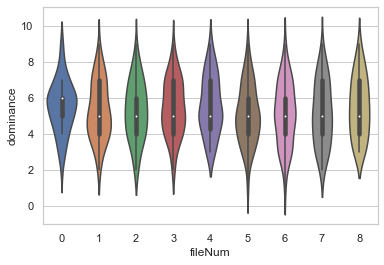

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# ax = sns.violinplot(x="fileNum", y="F0semitoneFrom27.5Hz_sma3nz_amean@NUMERIC", data=data)
# ax = sns.violinplot(x="fileNum", y="arousal", data=data)
# ax = sns.violinplot(x="fileNum", y="valence", data=data)
ax = sns.violinplot(x="fileNum", y="dominance", data=data)
